In [1]:
# Import required packages
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Get dataframe from quandl
df = quandl.get("WIKI/GOOGL")

# show first lines of data
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [2]:
# See columns names
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')

In [3]:
# Pick some columns as the data
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df.columns

Index(['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'], dtype='object')

In [4]:
# Add a couple of columns
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [5]:
# Rearrange the dataframe
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0


In [6]:
# Picking the label colum.
# Adjusted Close seems interesting, so
forecast_col = 'Adj. Close'

# Fill missing values with -99 999. The value is recommended
df.fillna(value=-99999, inplace=True)

# Pick a range for a valid forecast.
#with forecasting, you want to forecast out a certain number of datapoints. 
#We're saying we want to forecast out 1% of the entire length of the dataset.
#Thus, if our data is 100 days of stock prices, 
#we want to be able to predict the price 1 day out into the future. 
#Choose whatever you like. 
#If you are just trying to predict tomorrow's price, 
#then you would just do 1 day out, and the forecast would be just one day out. 
#If you predict 10 days out, we can actually generate a forcast for every day, 
#for the next week and a half.
# Picking 1% of the data set lenght
forecast_out = int(math.ceil(0.01 * len(df)))
forecast_out

33

In [7]:
# Add the label colum with name "label"
df['label'] = df[forecast_col].shift(-forecast_out)

In [8]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,68.752232
2004-08-20,54.322689,7.921706,7.227007,22834300.0,69.639972
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,69.078238
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,67.839414
2004-08-25,53.164113,3.886792,1.183658,9188600.0,68.912727


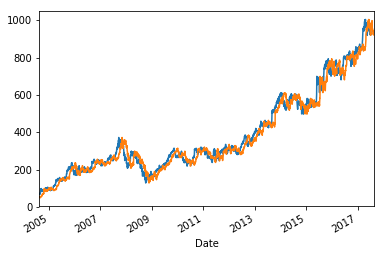

In [9]:
# Visually inspecting the data
import matplotlib.pyplot as plt
%matplotlib inline

df['label'].plot()
df['Adj. Close'].plot()
plt.show()

In [10]:
#Drop out any NaNs
df.dropna(inplace=True)

In [15]:
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

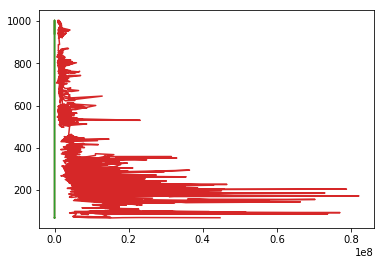

In [12]:
plt.plot(X,y)

In [11]:
df.corr()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Adj. Close,1.000000,-0.334277,-0.000161,-0.559126,0.986853
HL_PCT,-0.334277,1.000000,-0.092086,0.582348,-0.340998
PCT_change,-0.000161,-0.092086,1.000000,-0.024615,0.001808
Adj. Volume,-0.559126,0.582348,-0.024615,1.000000,-0.562767
label,0.986853,-0.340998,0.001808,-0.562767,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39d5f51748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f39d5ce2588>]], dtype=object)

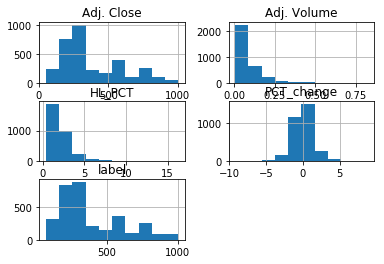

In [12]:
from pandas.plotting import scatter_matrix
df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39d5d4bac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f39d54c9668>]], dtype=object)

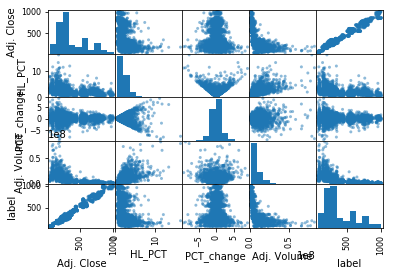

In [13]:
scatter_matrix(df)

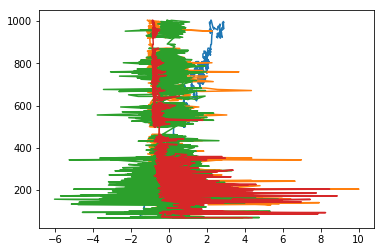

In [16]:
# Generally, you want your features in machine learning to be in a range of -1 to 1. 
#This may do nothing, but it usually speeds up processing and can also help with accuracy. 
#Because this range is so popularly used, it is included in the preprocessing module of Scikit-Learn. 
#To utilize this, you can apply preprocessing.scale to your X variable:
X = preprocessing.scale(X)
y = np.array(df['label'])
plt.plot(X,y)

In [26]:
#The way this works is you take, for example, 75% of your data,
#and use this to train the machine learning classifier. 
#Then you take the remaining 25% of your data, and test the classifier.
#Since this is your sample data, you should have the features and known labels.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
#The return here is the training set of features,
#testing set of features, training set of labels,
#and testing set of labels. Now, we're ready to plt.plot(X_test,y_test)
#define our classifier. There are many classifiers 
#in general available through Scikit-Learn, and even
#a few specifically for regression. We'll show a 
#couple in this example, but for now, let's use 
#Support Vector Regression from Scikit-Learn's svm package:
clf = svm.SVR()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.8116919163


In [29]:
clf = LinearRegression()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.972716318555


In [30]:
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence)

linear 0.970802564738
poly 0.681136655226
rbf 0.8116919163
sigmoid 0.893819978784


In [51]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
dsos_ = X.size
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

dshs_ = X.size
dsts_ = X_lately.size

df.dropna(inplace=True)

y = np.array(df['label'])
dslos_ = y.size
y = y[:-forecast_out]
dslns_ = y.size

print("Data sets sizes")
print("---------------")
print("head + tail = original size")
print(X.size,"+",X_lately.size,"=",X.size+X_lately.size)
print("Label sizes")
print(dslos_,dslns_)

Data sets sizes
---------------
head + tail = original size
12840 + 132 = 12972
Label sizes
3243 3210


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.973486580041


In [59]:
forecast_set = clf.predict(X_lately)

In [60]:
print(forecast_set, confidence, forecast_out)

[  968.98612819   978.49900744   984.64225345   992.21160268  1005.46361085
  1007.53213562  1010.77093768  1000.3054529   1002.30659908  1010.45707835
  1018.11441439  1010.41427175  1016.08618453  1018.55789571   979.04395614
   973.15389986   983.8714598    980.93898284   973.27451809   972.24481107
   989.36382637   982.78303825   992.94559801   991.16183554  1000.29445781
   984.59794199   960.57190902   973.33964722   949.82246718   942.56053822
   932.11763582   945.46083152   940.91510618] 0.973486580041 33


In [84]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

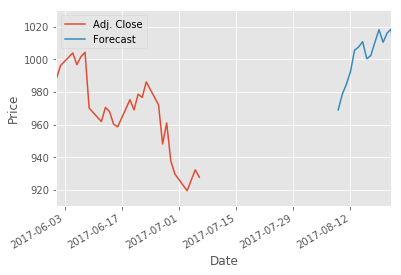

In [109]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.xlim([datetime.date(2017,6,1).toordinal(),datetime.date(2017,8,22).toordinal()])
plt.ylim([910,1030])
plt.show()